Data sudah stasioner.


C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

Best Parameters: (1, 0, 2), Seasonal: (1, 0, 1, 12)
Model saved at C:\Users\ASUS\Aplikasi_Skripsi\saved_models\sarimax_model.pkl
MSE: 41038.1834
RMSE: 202.5788
MAE: 99.1606
R2: 0.7273
MAPE: 22.73%


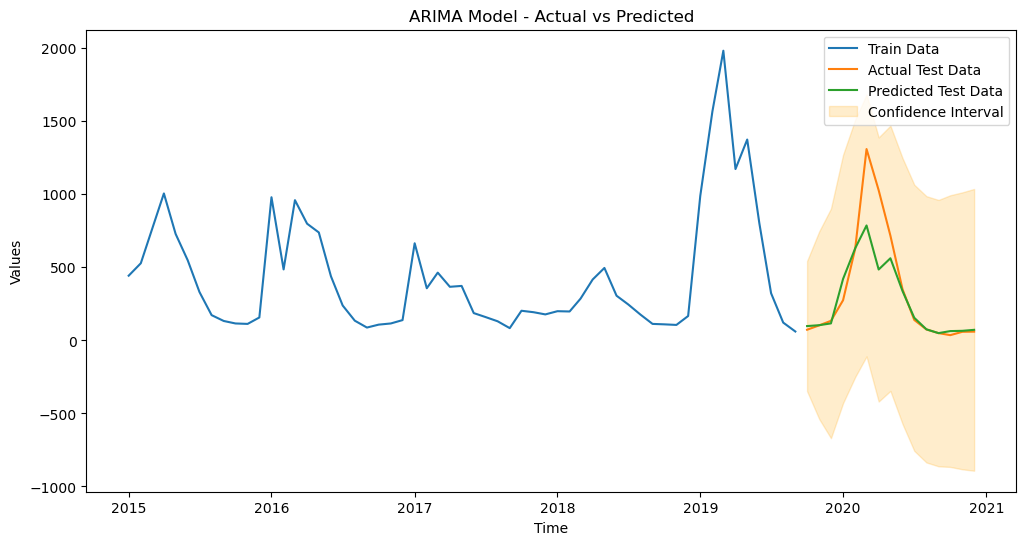

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt

# Load Dataset
data_path = r"C:\Users\ASUS\Downloads\ARIMA\data_kasus_ori.csv"
df = pd.read_csv(data_path)
df['periode'] = pd.to_datetime(df['periode'])
df.set_index('periode', inplace=True)

# Time Series Data
time_series = df['jumlah_kasus']

# Preprocessing: Scaling
scaler = MinMaxScaler()
scaled_time_series = scaler.fit_transform(time_series.values.reshape(-1, 1)).flatten()

# Check Stasionaritas
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    if result[1] <= 0.05:
        print("Data sudah stasioner.")
    else:
        print("Data tidak stasioner, melakukan differencing.")
        raise ValueError("Data tidak stasioner. Lakukan differencing atau transformasi.")

check_stationarity(scaled_time_series)

# Differencing jika perlu
def make_stationary(data):
    return data.diff().dropna()

# Train-Test Split
train_size = int(len(scaled_time_series) * 0.8)
train_data, test_data = scaled_time_series[:train_size], scaled_time_series[train_size:]

# Grid Search for Optimal Parameters
from itertools import product

def grid_search_arima(train_data):
    p = d = q = range(0, 3)
    P = D = Q = range(0, 2)
    seasonal_m = [12]
    
    best_score = float('inf')
    best_params = None
    for order in product(p, d, q):
        for seasonal_order in product(P, D, Q, seasonal_m):
            try:
                model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,
                                enforce_stationarity=False, enforce_invertibility=False)
                result = model.fit(disp=False)
                predictions = result.fittedvalues
                score = mean_squared_error(train_data, predictions)
                if score < best_score:
                    best_score = score
                    best_params = (order, seasonal_order)
            except:
                continue
    return best_params

best_order, best_seasonal_order = grid_search_arima(train_data)
print(f"Best Parameters: {best_order}, Seasonal: {best_seasonal_order}")

# Train Final Model
model = SARIMAX(train_data, order=best_order, seasonal_order=best_seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)

# Save Model
model_save_path = r"C:\Users\ASUS\Aplikasi_Skripsi\saved_models\sarimax_model.pkl"
with open(model_save_path, "wb") as f:
    pickle.dump({"model": result, "scaler": scaler}, f)
print(f"Model saved at {model_save_path}")

# Predict Test Data
forecast_steps = len(test_data)
forecast = result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_values_original_scale = scaler.inverse_transform(forecast_values.reshape(-1, 1)).flatten()

# Confidence Interval
conf_int = forecast.conf_int()

# Tangani tipe data conf_int
if isinstance(conf_int, pd.DataFrame):  # Jika conf_int adalah DataFrame
    lower_bound = scaler.inverse_transform(conf_int.iloc[:, 0].values.reshape(-1, 1)).flatten()
    upper_bound = scaler.inverse_transform(conf_int.iloc[:, 1].values.reshape(-1, 1)).flatten()
elif isinstance(conf_int, np.ndarray):  # Jika conf_int adalah numpy array
    lower_bound = scaler.inverse_transform(conf_int[:, 0].reshape(-1, 1)).flatten()
    upper_bound = scaler.inverse_transform(conf_int[:, 1].reshape(-1, 1)).flatten()
else:
    raise ValueError("Unexpected type for conf_int")

# Define actual_values
actual_values = time_series[train_size:].values  # Data aktual dari data testing

# 6. Evaluasi Model
mse = mean_squared_error(actual_values, forecast_values_original_scale)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, forecast_values_original_scale)
r2 = r2_score(actual_values, forecast_values_original_scale)
mape = mean_absolute_percentage_error(actual_values, forecast_values_original_scale) * 100


print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_series.index[:len(train_data)], scaler.inverse_transform(train_data.reshape(-1, 1)).flatten(),
         label="Train Data")
plt.plot(time_series.index[len(train_data):], actual_values, label="Actual Test Data")
plt.plot(time_series.index[len(train_data):], forecast_values_original_scale, label="Predicted Test Data")
plt.fill_between(time_series.index[len(train_data):], lower_bound, upper_bound, color="orange", alpha=0.2,
                 label="Confidence Interval")
plt.legend()
plt.title("ARIMA Model - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()